In [1]:
# Step 1: Import the necessary libraries

import os
import shutil
import tarfile
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [2]:

# Step 2: Load the dataset
# Get the current working directory

current_folder = os.getcwd()

dataset = tf.keras.utils.get_file(
    fname ="aclImdb.tar.gz",
    origin ="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    cache_dir=  current_folder,
    extract = True)


84125825/84125825 [==============================] - 22s 0us/step


In [3]:
dataset_path = os.path.dirname(dataset)
# Check the dataset
os.listdir(dataset_path)


['aclImdb', 'aclImdb.tar.gz']

In [4]:
# Dataset directory
dataset_dir = os.path.join(dataset_path, 'aclImdb')

# Check the Dataset directory
os.listdir(dataset_dir)


['train', 'README', 'imdbEr.txt', 'test', 'imdb.vocab']

In [5]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['unsup',
 'urls_neg.txt',
 'pos',
 'neg',
 'labeledBow.feat',
 'urls_unsup.txt',
 'unsupBow.feat',
 'urls_pos.txt']

In [6]:
# Read the files of the ‘Train’ directory files

for file in os.listdir(train_dir):
    file_path = os.path.join(train_dir, file)
    # Check if it's a file (not a directory)
    if os.path.isfile(file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            first_value = f.readline().strip()
            print(f"{file}: {first_value}")
    else:
        print(f"{file}: {file_path}")


unsup: /content/datasets/aclImdb/train/unsup
urls_neg.txt: http://www.imdb.com/title/tt0064354/usercomments
pos: /content/datasets/aclImdb/train/pos
neg: /content/datasets/aclImdb/train/neg
labeledBow.feat: 9 0:9 1:1 2:4 3:4 4:6 5:4 6:2 7:2 8:4 10:4 12:2 26:1 27:1 28:1 29:2 32:1 41:1 45:1 47:1 50:1 54:2 57:1 59:1 63:2 64:1 66:1 68:2 70:1 72:1 78:1 100:1 106:1 116:1 122:1 125:1 136:1 140:1 142:1 150:1 167:1 183:1 201:1 207:1 208:1 213:1 217:1 230:1 255:1 321:5 343:1 357:1 370:1 390:2 468:1 514:1 571:1 619:1 671:1 766:1 877:1 1057:1 1179:1 1192:1 1402:2 1416:1 1477:2 1940:1 1941:1 2096:1 2243:1 2285:1 2379:1 2934:1 2938:1 3520:1 3647:1 4938:1 5138:4 5715:1 5726:1 5731:1 5812:1 8319:1 8567:1 10480:1 14239:1 20604:1 22409:4 24551:1 47304:1
urls_unsup.txt: http://www.imdb.com/title/tt0018515/usercomments
unsupBow.feat: 0 0:8 1:6 3:5 4:2 5:1 7:1 8:5 9:2 10:1 11:2 13:3 16:1 17:1 18:1 19:1 22:3 24:1 26:3 28:1 30:1 31:1 35:2 36:1 39:2 40:1 41:2 46:2 47:1 48:1 52:1 63:1 67:1 68:1 74:1 81:1 83:1 

In [7]:
'''Load the Movies reviews and convert them into the pandas’ data frame with their respective sentiment
Here 0 means Negative and 1 means Positive'''

def load_dataset(directory):
    data = {"sentence": [], "sentiment": []}
    for file_name in os.listdir(directory):
        print(file_name)
        if file_name == 'pos':
            positive_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(positive_dir):
                text = os.path.join(positive_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(1)
        elif file_name == 'neg':
            negative_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(negative_dir):
                text = os.path.join(negative_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(0)

    return pd.DataFrame.from_dict(data)


In [8]:

# Load the dataset from the train_dir
train_df = load_dataset(train_dir)
print(train_df.head())


unsup
urls_neg.txt
pos
neg
labeledBow.feat
urls_unsup.txt
unsupBow.feat
urls_pos.txt
                                            sentence  sentiment
0  As I mentioned previously, John Carpenter's 19...          1
1  I always enjoyed watching this when it came on...          1
2  What a delightful film...<br /><br />Accompani...          1
3  I really didn't expect much from this movie, b...          1
4  Before George Clooney directed Sam Rockwell in...          1


In [9]:
# Load the test dataset respectively

test_dir = os.path.join(dataset_dir,'test')

# Load the dataset from the test_dir
test_df = load_dataset(test_dir)
print(test_df.head())


urls_neg.txt
pos
neg
labeledBow.feat
urls_pos.txt
                                            sentence  sentiment
0  I loved this film! It has a great heart and gr...          1
1  A £3.50 DVD can be a gamble and this was one t...          1
2  I remember watching this when it was made and ...          1
3  Brilliant work. Marvelous actors dissolve as b...          1
4  Where the heck is Andreas(Trond Fausa Aurvaag)...          1


In [10]:
# Step 3: Preprocessing

sentiment_counts = train_df['sentiment'].value_counts()

fig =px.bar(x= {0:'Negative',1:'Positive'},
            y= sentiment_counts.values,
            color=sentiment_counts.index,
            color_discrete_sequence =  px.colors.qualitative.Dark24,
            title='<b>Sentiments Counts')

fig.update_layout(title='Sentiments Counts',
                  xaxis_title='Sentiment',
                  yaxis_title='Counts',
                  template='plotly_dark')

# Show the bar chart
fig.show()
pyo.plot(fig, filename = 'Sentiments Counts.html', auto_open = True)


'Sentiments Counts.html'

In [11]:
# Text Cleaning

def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    return text


In [12]:
# Apply text_cleaning

# Train dataset
train_df['Cleaned_sentence'] = train_df['sentence'].apply(text_cleaning).tolist()
# Test dataset
test_df['Cleaned_sentence'] = test_df['sentence'].apply(text_cleaning)


In [13]:
# Plot reviews on WordCLouds


# Function to generate word cloud
def generate_wordcloud(text,Title):
    all_text = " ".join(text)
    wordcloud = WordCloud(width=800,
                          height=400,
                          stopwords=set(STOPWORDS),
                          background_color='black').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()


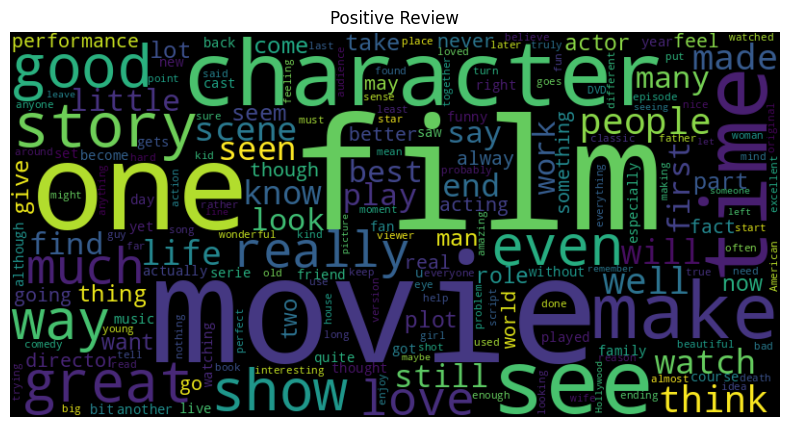

In [14]:
# Positive Reviews

positive = train_df[train_df['sentiment']==1]['Cleaned_sentence'].tolist()
generate_wordcloud(positive,'Positive Review')


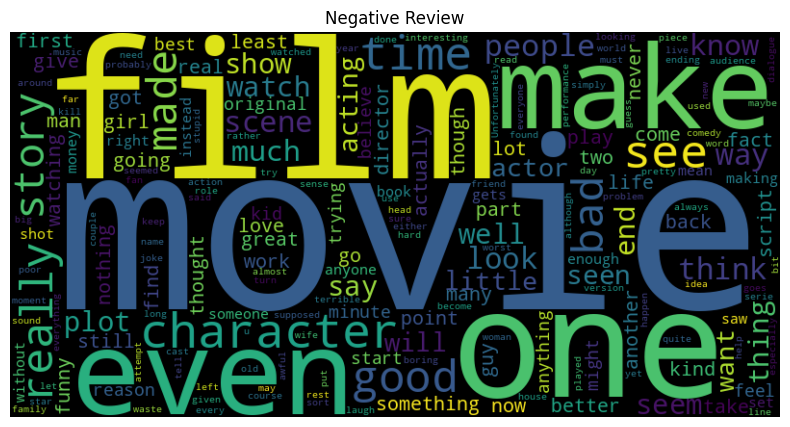

In [15]:
# Negative Reviews

negative = train_df[train_df['sentiment']==0]['Cleaned_sentence'].tolist()
generate_wordcloud(negative,'Negative Review')



In [16]:
# Separate input text and target sentiment of both train and test

# Training data
#Reviews = "[CLS] " +train_df['Cleaned_sentence'] + "[SEP]"
Reviews = train_df['Cleaned_sentence']
Target = train_df['sentiment']

# Test data
#test_reviews =  "[CLS] " +test_df['Cleaned_sentence'] + "[SEP]"
test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']


In [17]:
# Split TEST data into test and validation

x_val, x_test, y_val, y_test = train_test_split(test_reviews,
                                                    test_targets,
                                                    test_size=0.5,
                                                    stratify = test_targets)


In [18]:
# Step 4: Tokenization & Encoding

# Load the pre-trained BERT tokenizer

#Tokenize and encode the data using the BERT tokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [19]:
# Apply the BERT tokenization in training, testing and validation dataset

max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')



In [20]:
# Checking the encoded dataset
k = 0
print('Training Comments -->>',Reviews[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',Target[k])




Training Comments -->> As I mentioned previously, John Carpenter's 1978 classic is one of the first two movies I can remember seeing and being heavily influenced by the other being the classic Conan the Barbarian It so truly scared me that the only monster under my bed was Michael Meyers, whom I eventually befriended imaginary friend to keep him from killing me in my sleep Now that is terror for a 10 year oldIt is a horror classic and I am sure my modest review will not do it the justice it deserves The most surprising thing of all is that the movie still works, perhaps not in the guttural reaction but more of a cognitive possibility or immediate subconscious This all could happen It isn't in the realm of impossibility or located in a foreign country as most modern horror is, ie Hostel, Touristas, Cry Wolf, Saw,etc At times it is graphic while the rest is relegated to our imaginations I believe it is this element that keeps people terrified or at the very least wary of going outside at

In [21]:
# Step 5: Build the classification model

# Intialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# Compile the model

# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


In [24]:
# Train the model

# Step 5: Train the model
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    Target,
    validation_data=(
      [X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
    batch_size=32,
    epochs=2
)


Epoch 1/2
782/782 [==============================] - 761s 974ms/step - loss: 0.1882 - accuracy: 0.9282 - val_loss: 0.2897 - val_accuracy: 0.8846
Epoch 2/2
782/782 [==============================] - 761s 974ms/step - loss: 0.0976 - accuracy: 0.9662 - val_loss: 0.3678 - val_accuracy: 0.8886


In [25]:
# Step 6:Evaluate the model

#Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
    y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')


391/391 [==============================] - 109s 280ms/step - loss: 0.3541 - accuracy: 0.8883
Test loss: 0.35410356521606445, Test accuracy: 0.8883200287818909


In [26]:
# Save the model and tokenizer to the local folder

path = '/content'
# Save tokenizer
tokenizer.save_pretrained(path +'/Tokenizer')

# Save model
model.save_pretrained(path +'/Model')


In [27]:
# Load the model and tokenizer from the local folder

# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer')

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model')


Some layers from the model checkpoint at /content/Model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [28]:
# Predict the sentiment of the test dataset

pred = bert_model.predict(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

# pred is of type TFSequenceClassifierOutput
logits = pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

label = {
    1: 'positive',
    0: 'Negative'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print('Predicted Label :', pred_labels[:10])
print('Actual Label    :', Actual[:10])


391/391 [==============================] - 114s 275ms/step
Predicted Label : ['positive', 'positive', 'Negative', 'Negative', 'Negative', 'positive', 'Negative', 'Negative', 'Negative', 'positive']
Actual Label    : ['positive', 'Negative', 'positive', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative']


In [29]:
# Classification Report

print("Classification Report: \n", classification_report(Actual, pred_labels))


Classification Report: 
               precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      6250
    positive       0.88      0.90      0.89      6250

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500



In [30]:
# Step 7: Prediction with user inputs

def Get_sentiment(Review, Tokenizer=bert_tokenizer, Model=bert_model):
    # Convert Review to a list if it's not already a list
    if not isinstance(Review, list):
        Review = [Review]

    Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review,
                                                                             padding=True,
                                                                             truncation=True,
                                                                             max_length=128,
                                                                             return_tensors='tf').values()
    prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])

    # Use argmax along the appropriate axis to get the predicted labels
    pred_labels = tf.argmax(prediction.logits, axis=1)

    # Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
    pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
    return pred_labels


In [39]:
#  Let’s predict with our own review

Review =''' I absolutely  did loved the breathtaking scenery and incredible performances in the movie!"'''
Get_sentiment(Review)



1/1 [==============================] - 0s 74ms/step


['positive']

In [40]:
#  Let’s predict with our own review

Review =''' I absolutely  did not  loved the breathtaking scenery and incredible performances in the movie!"'''
Get_sentiment(Review)



1/1 [==============================] - 0s 51ms/step


['Negative']